# Air Pressure Forecasting on Beijing Air Quality dataset

The data set is obtained from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data). Beijing's official air-quality statistics are composed using hourly data from different stations. This study has a focus on Air Pressure achieved from Aotizhongxin station between March 2013 to February 2017. The pressure feature in this data set has several missing values. These values are sorted out using the average strategy to fill them out. The preprocessing and manipulating are done to make the data ready for more analysis. In addition, the last years of data are employed for the test set to assess the final model. The rest of the data is used to train the LSTM network. LSTM networks are well-suited for classifying, processing, and making predictions based on time series data. This is a complex area of deep learning that is difficult to interpret, but precise to predict the sequential data.

The result shows that the mean squared error for the fitted model is around 0.0002 which is perfect for the forecasting process.

It should be noted that the codes are executed in the Google Colab using Python 3 kernel.

In [1]:
# import libreries and packages
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.tsa import stattools
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import models, layers, regularizers, wrappers
from google.colab import files

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
uploaded = files.upload()

Saving PRSA_Data_Aotizhongxin_20130301-20170228.csv to PRSA_Data_Aotizhongxin_20130301-20170228 (4).csv


In [3]:
import io
Data = pd.read_csv(io.BytesIO(uploaded['PRSA_Data_Aotizhongxin_20130301-20170228.csv']))

## Looking at the data

In [4]:
Data.columns

Index(['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2',
       'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station'],
      dtype='object')

In [5]:
# Check the shape of data set
Data.shape

(35064, 18)

In [6]:
# a concise summary of a Data
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       35064 non-null  int64  
 1   year     35064 non-null  int64  
 2   month    35064 non-null  int64  
 3   day      35064 non-null  int64  
 4   hour     35064 non-null  int64  
 5   PM2.5    34139 non-null  float64
 6   PM10     34346 non-null  float64
 7   SO2      34129 non-null  float64
 8   NO2      34041 non-null  float64
 9   CO       33288 non-null  float64
 10  O3       33345 non-null  float64
 11  TEMP     35044 non-null  float64
 12  PRES     35044 non-null  float64
 13  DEWP     35044 non-null  float64
 14  RAIN     35044 non-null  float64
 15  wd       34983 non-null  object 
 16  WSPM     35050 non-null  float64
 17  station  35064 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 4.8+ MB


In [7]:
# Pressure feature description
Data['PRES'].describe().round(2)

count    35044.00
mean      1011.85
std         10.40
min        985.90
25%       1003.30
50%       1011.40
75%       1020.10
max       1042.00
Name: PRES, dtype: float64

## Data Preparation

In [8]:
# The pressure feature has several missing values

# Function to impute missing data
def missing_values (df, col):
  avg = df[col].mean()
  df[col+"_imputed"] = df[col]
  df[col+"_imputed"].fillna(avg, inplace=True)

# impute pressure feature
missing_values(df=Data, col="PRES")

In [9]:
print('number of missing value before imputing for pressure feature:', Data['PRES'].isnull().sum())
print('-'*70)
print('number of missing value after imputing for pressure feature:',Data['PRES_imputed'].isnull().sum())

number of missing value before imputing for pressure feature: 20
----------------------------------------------------------------------
number of missing value after imputing for pressure feature: 0


In [10]:
# make a column for date time
Data['datetime'] =  Data[['year', 'month', 'day', 'hour']].apply(lambda row: datetime.datetime(year=row['year'], month=row['month'], day=row['day'], hour=row['hour']), axis=1)

In [11]:
# Sort by the date time
Data.sort_values('datetime', ascending=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


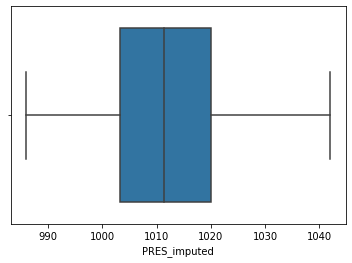

In [12]:
# box plot to show distributions with respect to pressure
sns.boxplot(Data['PRES_imputed'])

Text(0, 0.5, 'Air Pressure readings in hPa')

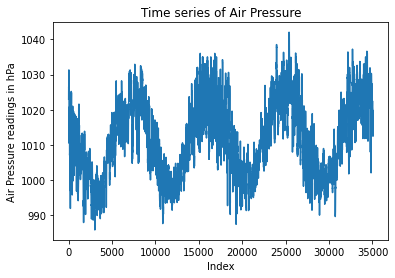

In [13]:
# pressure feature
plt.plot(Data['PRES_imputed'])
plt.title('Time series of Air Pressure')
plt.xlabel('Index')
plt.ylabel('Air Pressure readings in hPa')

Augmented Dickey–Fuller (ADF) test for a unit root in a univariate process in the presence of serial.
**ADF** tests the null hypothesis that a unit root is present in a time series sample.

In [14]:
t = stattools.adfuller(Data['PRES_imputed'])
print('The p-value is: ', t[1])

The p-value is:  3.93081270892354e-14


When the p-value is smaller than significance level at $\alpha=0.05$, the null hypothesis may be rejected.

In [15]:
# Split data into train and test sets
split_date = datetime.datetime(year=2016, month=2, day=28, hour=0)
Data_train = Data.loc[Data['datetime']<split_date]
Data_test = Data.loc[Data['datetime']>=split_date]

In [16]:
print('Shape of train:', Data_train.shape)
print('Shape of test:', Data_test.shape)

Shape of train: (26256, 20)
Shape of test: (8808, 20)


In [17]:
# Select the imputed pressure feature for the rest of the analysis 

# Find column index
ci = Data.columns.get_loc("PRES_imputed")
print(ci)

PRES_train = Data_train.iloc[:, ci:ci+1].values
PRES_test = Data_test.iloc[:, ci:ci+1].values

18


In [18]:
# Data Normalization on train and test sets
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_PRES_train = scaler.fit_transform(PRES_train)
scaled_PRES_test = scaler.fit_transform(PRES_test)

In [19]:
#Convert Training Data to Right Shape
x_train = []
y_train = []
# Execute a loop for making supervised data for forecasting process
for i in range(7, Data_train.shape[0]):
  x_train.append(scaled_PRES_train[i-7:i, 0])
  y_train.append(scaled_PRES_train[i, 0])

In [20]:
# Convert both training lists to numpy.array
x_train, y_train = np.array(x_train), np.array(y_train)

In [21]:
# Convert testing Data to Right Shape
x_test = []
y_test = []
# Execute a loop for making supervised data for forecasting
for i in range(7, Data_test.shape[0]):
  x_test.append(scaled_PRES_test[i-7:i, 0])
  y_test.append(scaled_PRES_test[i, 0])

In [22]:
# Convert both testing lists to numpy.array
x_test, y_test = np.array(x_test), np.array(y_test)

In [23]:
# Reshape train and test sets to the right shape for LSTM
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)


In [24]:
print('Shape of train arrays:', x_train.shape, y_train.shape)
print('Shape of test arrays:', x_test.shape, y_test.shape)

Shape of train arrays: (26249, 7, 1) (26249,)
Shape of test arrays: (8801, 7, 1) (8801,)


## Model Creation for the Forecasting

In [25]:
# Ctreate LSTM network
model = models.Sequential()
# input layer and hidden layer
model.add(layers.LSTM(units=64, input_shape=(x_train.shape[1],1)))
model.add(layers.Dropout(0.2))  # Dropout layer to prevent overfitting
# Output layer
model.add(layers.Dense(units=1))
# Compile the model
model.compile(optimizer = 'adamax', loss = 'mse', metrics=['mse'])

In [26]:
model.fit(x=x_train, y=y_train, batch_size=16 ,epochs=20)

Epoch 1/20
1641/1641 [==============================] - 9s 4ms/step - loss: 0.0099 - mse: 0.0099
Epoch 2/20
1641/1641 [==============================] - 7s 4ms/step - loss: 0.0019 - mse: 0.0019
Epoch 3/20
1641/1641 [==============================] - 7s 4ms/step - loss: 0.0013 - mse: 0.0013
Epoch 4/20
1641/1641 [==============================] - 7s 4ms/step - loss: 0.0010 - mse: 0.0010
Epoch 5/20
1641/1641 [==============================] - 7s 4ms/step - loss: 8.6439e-04 - mse: 8.6439e-04
Epoch 6/20
1641/1641 [==============================] - 7s 4ms/step - loss: 7.1681e-04 - mse: 7.1681e-04
Epoch 7/20
1641/1641 [==============================] - 7s 4ms/step - loss: 6.3316e-04 - mse: 6.3316e-04
Epoch 8/20
1641/1641 [==============================] - 7s 4ms/step - loss: 5.9599e-04 - mse: 5.9599e-04
Epoch 9/20
1641/1641 [==============================] - 7s 4ms/step - loss: 5.6543e-04 - mse: 5.6543e-04
Epoch 10/20
1641/1641 [==============================] - 7s 4ms/step - loss: 5.1524e-04

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


## Model Evaluation

In [28]:
# Prediction on train and test sets
train_Prediction = model.predict(x_train) 
test_Prediction = model.predict(x_test)

# Predicted values on test set should be inverted from scaled transform
converted_Prediction = scaler.inverse_transform(test_Prediction)

In [29]:
# Calculate root mean squared error for train and test set
testScore = math.sqrt(mean_squared_error(y_test, test_Prediction))
print('Test loss: %.3f RMSE' % (testScore))

trainScore = math.sqrt(mean_squared_error(y_train, train_Prediction))
print('Train loss: %.3f RMSE' % (trainScore))

Test loss: 0.016 RMSE
Train loss: 0.018 RMSE


The result shows that the fitted model is neither under- nor over-fitted.

In [30]:
# Evaluate the network
sc = model.evaluate(x_test, y_test)

276/276 [==============================] - 1s 2ms/step - loss: 2.4041e-04 - mse: 2.4041e-04


In [33]:
print("%s: %.4f" % (model.metrics_names[1], sc[1]))

mse: 0.0002


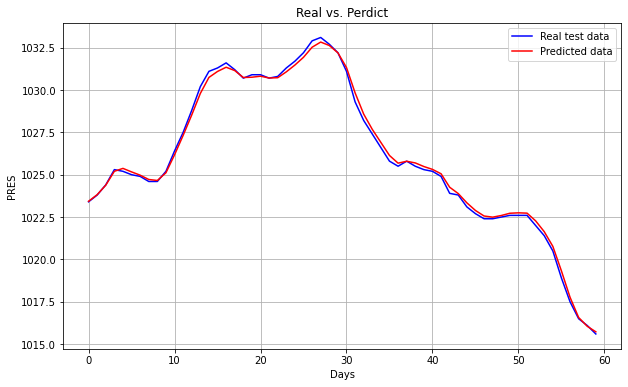

In [36]:
# Plot test and predict data for 60 days
plt.figure(figsize=(10,6))
plt.plot(PRES_test[6:66], color='blue', label='Real test data')
plt.plot(converted_Prediction[:60], color='red', label='Predicted data')
plt.title('Real vs. Perdict')
plt.xlabel('Days')
plt.ylabel('PRES')
plt.legend()
plt.grid()
plt.show()